### Routing: Directing Inputs to Specialized Processes

Routing is a fundamental agentic workflow pattern that involves intelligently classifying incoming inputs and directing them to the most appropriate specialized process or handler. Think of it as a sophisticated traffic controller that ensures each request reaches the right destination based on its characteristics and requirements.

This pattern operates on the principle that different types of queries require different handling strategies. Rather than using a one-size-fits-all approach, routing ensures that each input is processed by the most suitable component, leading to improved efficiency, accuracy, and resource utilization.

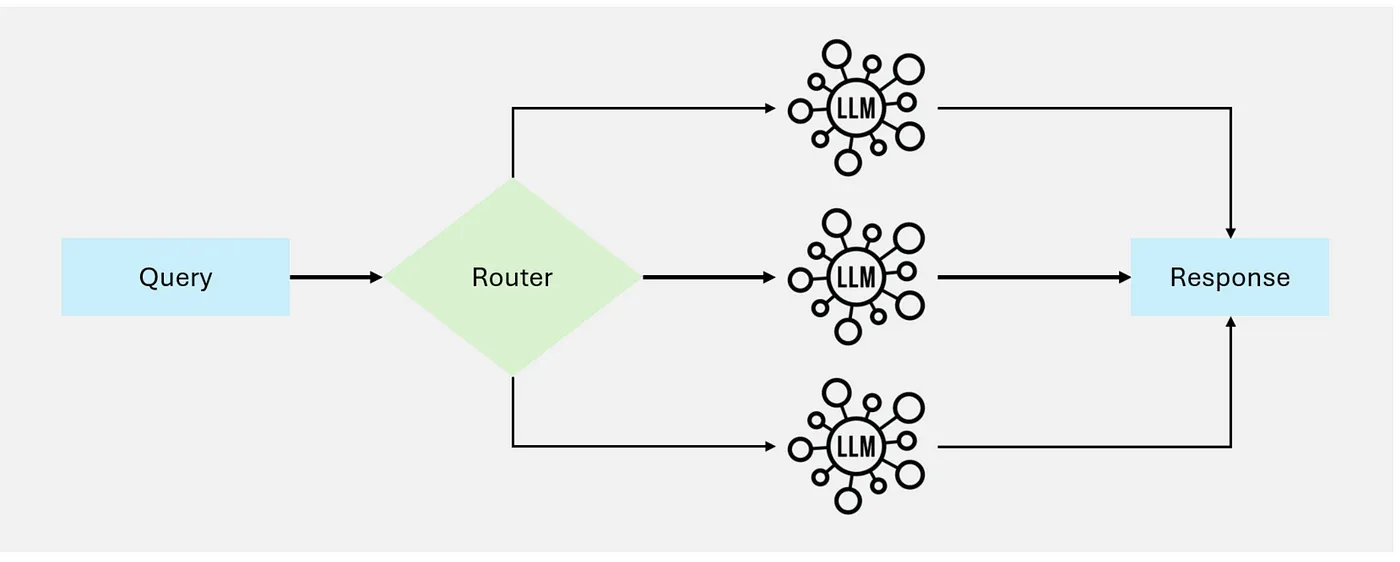

This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.




### Step 1: Setting Up the Environment


In [ ]:
from dotenv import load_dotenv
load_dotenv()

from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Initialize the language model for routing and processing
language_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")


### Step 2: Defining the Routing Schema


In [10]:
# Define the routing decision schema for structured output
class ContentRoute(BaseModel):
    """Schema for routing creative content requests"""
    content_type: Literal["story", "poem", "joke"] = Field(
        description="The type of creative content to generate"
    )

# Create a structured router using the schema
content_router = language_model.with_structured_output(ContentRoute)


### Step 3: Creating the Workflow State


In [2]:
# Define the state structure for our routing workflow
class RoutingState(TypedDict):
    user_input: str          # Original user request
    routing_decision: str    # Decision made by router
    final_output: str        # Generated content

### Step 4: Implementing Specialized Content Handlers


In [3]:
def generate_story(state: RoutingState):
    """Specialized handler for story generation"""
    story_prompt = f"Write an engaging short story based on: {state['user_input']}"
    response = language_model.invoke(story_prompt)
    return {"final_output": response.content}

def generate_poem(state: RoutingState):
    """Specialized handler for poem generation"""
    poem_prompt = f"Create a creative poem inspired by: {state['user_input']}"
    response = language_model.invoke(poem_prompt)
    return {"final_output": response.content}

def generate_joke(state: RoutingState):
    """Specialized handler for joke generation"""
    joke_prompt = f"Write a funny, clean joke about: {state['user_input']}"
    response = language_model.invoke(joke_prompt)
    return {"final_output": response.content}

### Step 5: Building the Router Logic

In [4]:
def route_content_request(state: RoutingState):
    """Analyze input and determine the appropriate content type"""
    routing_messages = [
        SystemMessage(
            content="Analyze the user's request and determine if they want a story, poem, or joke. "
                   "Consider keywords, tone, and intent in your decision."
        ),
        HumanMessage(content=state["user_input"])
    ]
    
    decision = content_router.invoke(routing_messages)
    return {"routing_decision": decision.content_type}

### Step 6: Implementing Conditional Routing


In [5]:
def determine_next_step(state: RoutingState):
    """Conditional function to route to the appropriate handler"""
    routing_map = {
        "story": "generate_story",
        "poem": "generate_poem", 
        "joke": "generate_joke"
    }
    return routing_map.get(state["routing_decision"], "generate_story")

### Step 7: Building and Compiling the Workflow


In [7]:
# Create the routing workflow graph
routing_graph = StateGraph(RoutingState)

# Add all processing nodes
routing_graph.add_node("route_content_request", route_content_request)
routing_graph.add_node("generate_story", generate_story)
routing_graph.add_node("generate_poem", generate_poem)
routing_graph.add_node("generate_joke", generate_joke)

# Define the workflow connections
routing_graph.add_edge(START, "route_content_request")

# Add conditional routing based on decision
routing_graph.add_conditional_edges(
    "route_content_request",
    determine_next_step,
    {
        "generate_story": "generate_story",
        "generate_poem": "generate_poem",
        "generate_joke": "generate_joke"
    }
)

# Connect all handlers to the end
routing_graph.add_edge("generate_story", END)
routing_graph.add_edge("generate_poem", END)
routing_graph.add_edge("generate_joke", END)

# Compile the workflow
content_routing_workflow = routing_graph.compile()

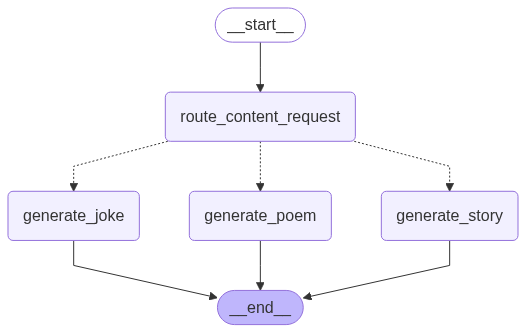

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        content_routing_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Step 8: Testing the Routing System

In [11]:
# Test the routing system with different inputs
test_inputs = [
    "Tell me something funny about artificial intelligence",
    "I want to hear a tale about a brave knight",
    "Create something poetic about the ocean"
]

for user_request in test_inputs:
    print(f"\n--- Processing: '{user_request}' ---")
    
    result = content_routing_workflow.invoke({
        "user_input": user_request
    })
    
    print(f"Routed to: {result['routing_decision']}")
    print(f"Output: {result['final_output'][:100]}...")


--- Processing: 'Tell me something funny about artificial intelligence' ---
Routed to: joke
Output: Why did the AI cross the road? 

Because the algorithm said it was the optimal path to the other sid...

--- Processing: 'I want to hear a tale about a brave knight' ---
Routed to: story
Output: Sir Kaelen the Bold, they called him. Bold, perhaps, but also perpetually dusty. He preferred the fe...

--- Processing: 'Create something poetic about the ocean' ---
Routed to: poem
Output: The ocean breathes, a turquoise lung,
Expanding wide where sky has clung.
A whispered sigh on sandy ...
